In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import qutip as q
import time

In [11]:
# Funcion que me devuelve el operador de espin en una cierta componente y el operador de spin total
def spin_operator(N, component):
    """
    N: int (numero de qubits)
    Component: str (componente del momento angular, 'x', 'y', 'z')
    returns Qobj
    """
    if component == 'x':
        op = q.sigmax()
    elif component == 'y':
        op = q.sigmay()
    elif component == 'z':
        op = q.sigmaz()
    else: 
        raise ValueError('La componente tiene que se x, y, o z')
    
    # Construimos los operadores
    total_operator = 0
    indv_operators = []
    for i in range(N):
        operators = [q.qeye(2) for _ in range(N)]
        operators[i] = op
        indv_operators.append(q.tensor(operators))
        total_operator += q.tensor(operators)
    
    return total_operator, indv_operators


# Funcion que me da el hamiltoniano de Ising cuantico y su operador de salto
def ising(params, N):
    # Parametros
    om = params[0]
    v = params[1]
    a = params[2]
    gam = params[3]
    
    # Sacamos los terminos
    spin_z = spin_operator(N, component = 'z')[1]
    todo_x = spin_operator(N, component = 'x')[0]
    spin_x = spin_operator(N, component = 'x')[1]
    spin_y = spin_operator(N, component = 'y')[1]
    
    list_J = []
    suma = 0
    for i in range(len(spin_z)):
        list_J.append((np.sqrt(gam)/2)*(spin_x[i] - 1.j*spin_y[i]))
        for j in range(len(spin_z)):
            if(i < j):
                suma += (spin_z[i]*spin_z[j])/(np.abs(i-j)**a)
                
    H = om*todo_x + v*suma
    return H, list_J

# Funcion que me permite obtener la matriz densidad de la que hablan en el articulo
def densidad(N):
    return q.basis(int(2**N), 0)*(q.basis(int(2**N), 0)).dag(), q.basis(int(2**N), 0)

# Funcion que me da el hamiltoniano y el operador de salto del modelo de Ising pero para a tendiendo a infinito
def ising_inf(params, N):
    # Parametros
    om = params[0]
    v = params[1]
    a = params[2]
    gam = params[3]
    
    # Sacamos los terminos
    spin_z = spin_operator(N, component = 'z')[1]
    todo_x = spin_operator(N, component = 'x')[0]
    spin_x = spin_operator(N, component = 'x')[1]
    spin_y = spin_operator(N, component = 'y')[1]
    
    list_J = []
    suma = 0
    for i in range(len(spin_z)):
        list_J.append((np.sqrt(gam)/2)*(spin_x[i] - 1.j*spin_y[i]))
        for j in range(len(spin_z)):
            if(i < j):
                suma += spin_z[i]*spin_z[j]/np.abs(i-j)**a
                
    H = om*todo_x
    return H, list_J

# Funcion que representa la esfera parametrizada segun angulos
def parametrizacion_esfera(r, theta_range, phi_range):
    theta_values = np.linspace(*theta_range, num = 100)
    phi_values = np.linspace(*phi_range, num = 100)
    
    theta, phi = np.meshgrid(theta_values, phi_values)
    
    x = r * np.sin(theta)*np.cos(phi)
    y = r* np.sin(theta)*np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z

# Funcion que representa en la esfera los valores de los angulos que yo quiera
def esfera_partes(r, theta_values, phi_values):
    theta, phi = np.meshgrid(theta_values, phi_values)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z
# Funcion que me permite obtener la matriz densidad de la que hablan en el articulo
def densidad(N):
    return q.basis(int(2**N), 0)*(q.basis(int(2**N), 0)).dag(), q.basis(int(2**N), 0)

# Funcion que me devuelve el operador de espin en una cierta componente y el operador de spin total
def spin_operator(N, component):
    """
    N: int (numero de qubits)
    Component: str (componente del momento angular, 'x', 'y', 'z')
    returns Qobj
    """
    if component == 'x':
        op = q.sigmax()
    elif component == 'y':
        op = q.sigmay()
    elif component == 'z':
        op = q.sigmaz()
    else: 
        raise ValueError('La componente tiene que se x, y, o z')
    
    # Construimos los operadores
    total_operator = 0
    indv_operators = []
    for i in range(N):
        operators = [q.qeye(2) for _ in range(N)]
        operators[i] = op
        indv_operators.append(q.tensor(operators))
        total_operator += q.tensor(operators)
    
    return total_operator, indv_operators

# Funcion que nos construye la transformacion de Mpemba, pero a base de transformaciones a un solo qubit
def Mpemba_sep(theta, phi, N):
    iden = q.qeye(int(2**N))
    spin_z = spin_operator(N, component = 'z')[1]
    spin_y = spin_operator(N, component = 'y')[1]
    #spin_z = [q.tensor(q.qeye(M), elemento) for elemento in dicke.spin_operator(N, 'z')[1]]
    #spin_y = [q.tensor(q.qeye(M), elemento) for elemento in dicke.spin_operator(N, 'y')[1]]
    res = iden.full()
    #print(iden.shape, spin_z[0].shape)
    
    for i in range(N):
        U1 = np.cos(0.5*phi)*iden.full() + 1.j*np.sin(0.5*phi)*spin_z[i].full()
        U2 = np.cos(0.5*theta)*iden.full() + 1.j*np.sin(0.5*theta)*spin_y[i].full()
        res = np.dot(np.dot(U1, U2), res)
    return q.Qobj(res)


# Funcion que me busca los angulos que me permiten acelerar el decaimiento
def buscar_angulos(L1, d0, N):
    epsilon = np.abs(np.trace(np.dot(L1, d0)))
    #epsilon = np.abs((L1*d0).tr())
    #epsilon = 1e-2
    posibles = []
    phi = 0.0
    theta = 0.0
    traza = []
    
    while(theta < np.pi):
        phi = 0.0
        while(phi < 2.0*np.pi):
            U = Mpemba_sep(theta, phi, N)
            #new_rho = U*d0*U.dag()
            new_rho = np.dot(U.full(), np.dot(d0, np.conjugate((U.full()).T)))
            res = np.trace(np.dot(L1, new_rho))
            #res = (L1*new_rho).tr()
            if(np.abs(res) < epsilon):
                posibles.append([theta, phi])
                traza.append(np.abs(res))
            phi += 0.1
        theta += 0.1
    
    return posibles, traza



0
0 4.0 0.1
1 3.6454545454545455 0.1
2 3.290909090909091 0.1
3 2.9363636363636365 0.1
4 2.581818181818182 0.1
5 2.2272727272727275 0.1
6 1.8727272727272726 0.1
7 1.518181818181818 0.1
8 1.1636363636363636 0.1
9 0.8090909090909091 0.1
10 0.4545454545454546 0.1
11 0.1 0.1
1
0 4.0 0.7272727272727273
1 3.6454545454545455 0.7272727272727273
2 3.290909090909091 0.7272727272727273
3 2.9363636363636365 0.7272727272727273
4 2.581818181818182 0.7272727272727273
5 2.2272727272727275 0.7272727272727273
6 1.8727272727272726 0.7272727272727273
7 1.518181818181818 0.7272727272727273
8 1.1636363636363636 0.7272727272727273
9 0.8090909090909091 0.7272727272727273
10 0.4545454545454546 0.7272727272727273
11 0.1 0.7272727272727273
2
0 4.0 1.3545454545454547
1 3.6454545454545455 1.3545454545454547
2 3.290909090909091 1.3545454545454547
3 2.9363636363636365 1.3545454545454547
4 2.581818181818182 1.3545454545454547
5 2.2272727272727275 1.3545454545454547
6 1.8727272727272726 1.3545454545454547
7 1.518181818

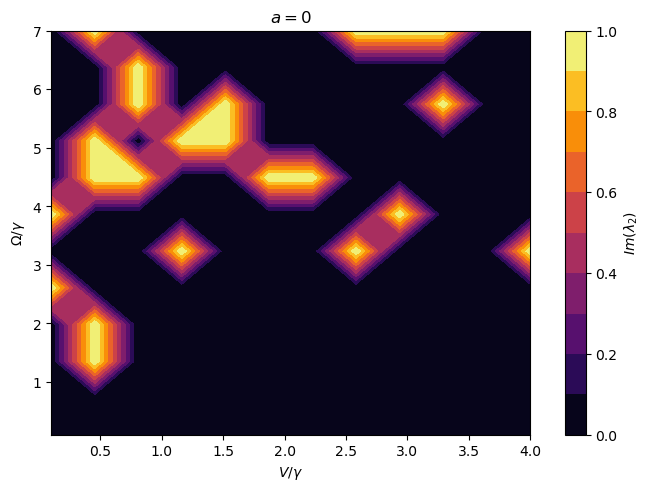

Tiempo: 3478.9036531448364


In [15]:
inicio = time.time()

# Elegimos los parametros queno van a cambiar
gam = 1
a = 0
N = 5
om_values = np.linspace(4, 0.1, 12)
v_values = np.linspace(0.1, 7, 12)
X, Y = np.meshgrid(om_values, v_values)
Z = np.zeros_like(X)
d0, ini = densidad(N)
A_total =(2*np.pi**2)/(0.3**2)
# Recorremos los valores de los parametros
vector_params = []
for i in range(X.shape[0]):
    print(i)
    for j in range(X.shape[1]):
        print(j, X[i, j], Y[i, j])
        params = [X[i, j]*gam, Y[i, j]*gam, a, gam]
        H, list_J = ising(params, N)
        L = q.liouvillian(H, list_J)
        todoh = (L.dag()).eigenstates(sparse = True, sort = 'high', eigvals = N-2, maxiter = 1e7)
        vals, vects = todoh
        if(np.isclose(vals[1], vals[2]) == True):
            Z[i, j] = 1
            vector_params.append([X[i, j], Y[i, j]])
        #Z[i, j] = vals[1]
        #Z[i, j] = sorted(vals, key = np.real)[1]
        
# Representamos 
fig1, ax2 = plt.subplots(layout='constrained')
#CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone)
CS = ax2.contourf(X, Y, Z, 10, cmap = 'inferno')
#CS = ax2.contourf(X, Y, Z, 10, cmap = 'viridis')
# Note that in the following, we explicitly pass in a subset of the contour
# levels used for the filled contours.  Alternatively, we could pass in
# additional levels to provide extra resolution, or leave out the *levels*
# keyword argument to use all of the original levels.

#CS2 = ax2.contour(CS, levels=CS.levels[::2], colors='r')

ax2.set_title(r'$a = 0$')
ax2.set_xlabel(r'$V / \gamma$')
ax2.set_ylabel(r'$\Omega / \gamma$')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel(r'$Im(\lambda_2)$')
# Add the contour line levels to the colorbar
#cbar.add_lines(CS2)
    
plt.show()

fin = time.time()
print('Tiempo: ' + str(fin-inicio))

In [16]:
vector_params

[[0.4545454545454546, 1.3545454545454547],
 [0.4545454545454546, 1.981818181818182],
 [0.1, 2.6090909090909093],
 [4.0, 3.2363636363636368],
 [2.581818181818182, 3.2363636363636368],
 [1.1636363636363636, 3.2363636363636368],
 [2.9363636363636365, 3.8636363636363638],
 [0.1, 3.8636363636363638],
 [2.2272727272727275, 4.490909090909091],
 [1.8727272727272726, 4.490909090909091],
 [0.8090909090909091, 4.490909090909091],
 [0.4545454545454546, 4.490909090909091],
 [1.518181818181818, 5.118181818181818],
 [1.1636363636363636, 5.118181818181818],
 [0.4545454545454546, 5.118181818181818],
 [3.290909090909091, 5.745454545454545],
 [1.518181818181818, 5.745454545454545],
 [0.8090909090909091, 5.745454545454545],
 [0.8090909090909091, 6.372727272727273],
 [3.290909090909091, 7.0],
 [2.9363636363636365, 7.0],
 [2.581818181818182, 7.0],
 [0.4545454545454546, 7.0]]

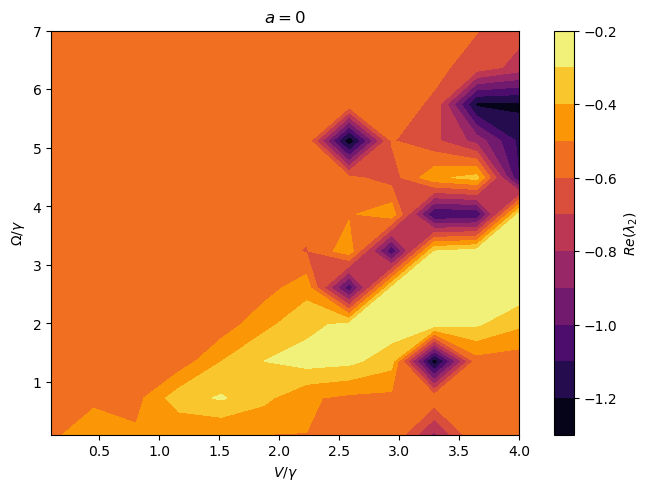

In [4]:
# Representamos 
fig1, ax2 = plt.subplots(layout='constrained')
#CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone)
CS = ax2.contourf(X, Y, np.real(Z), 10, cmap = 'inferno')
#CS = ax2.contourf(X, Y, Z, 10, cmap = 'viridis')
# Note that in the following, we explicitly pass in a subset of the contour
# levels used for the filled contours.  Alternatively, we could pass in
# additional levels to provide extra resolution, or leave out the *levels*
# keyword argument to use all of the original levels.

#CS2 = ax2.contour(CS, levels=CS.levels[::2], colors='r')

ax2.set_title(r'$a = 0$')
ax2.set_xlabel(r'$V / \gamma$')
ax2.set_ylabel(r'$\Omega / \gamma$')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel(r'$Re(\lambda_2)$')
# Add the contour line levels to the colorbar
#cbar.add_lines(CS2)
    
plt.show()

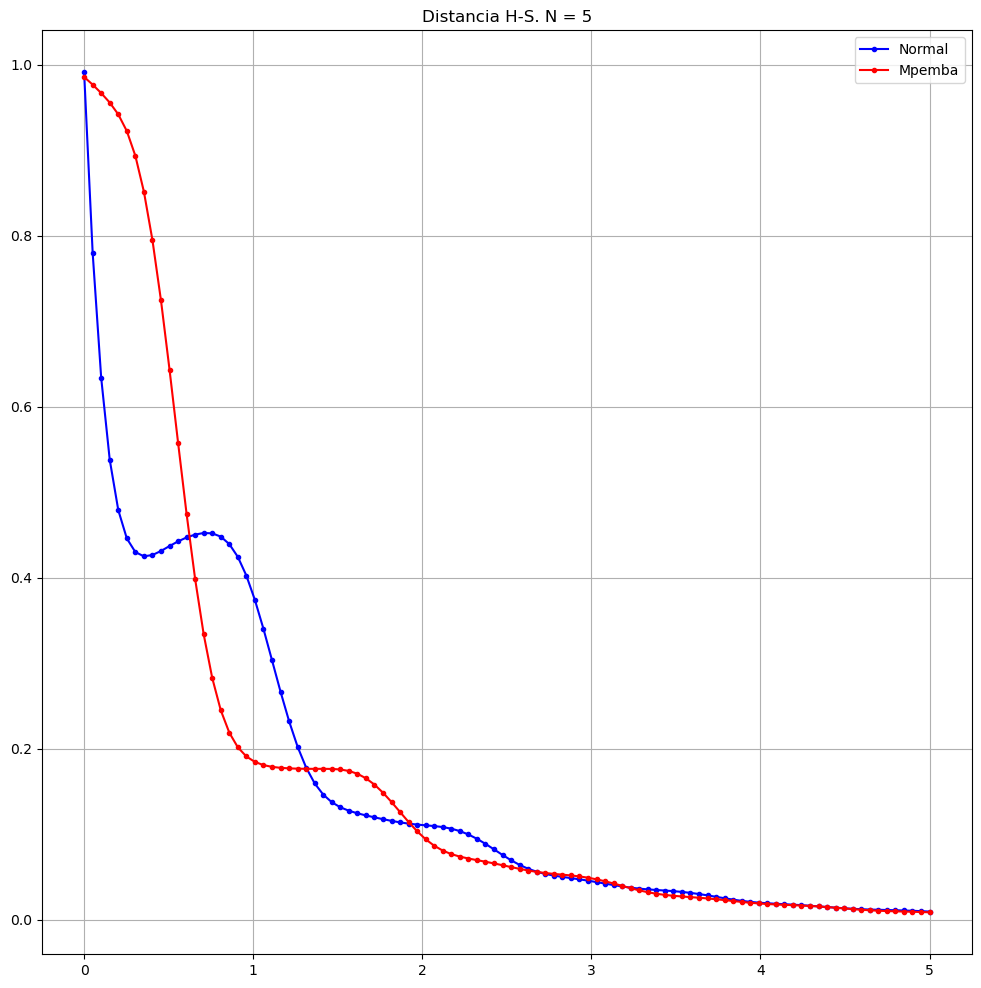

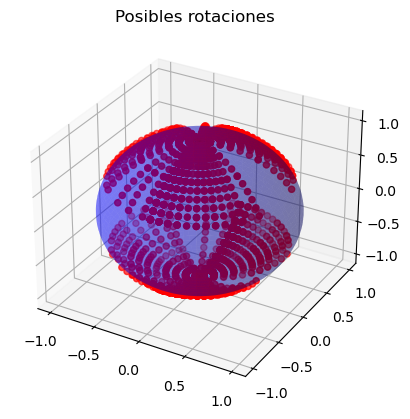

In [17]:
# Parametros
N = 5
i = 0
v, om = vector_params[i]
om = 2.4
v = 0.1
#a = 1
a = 0
gam = 1
params = [om, v, a, gam]

# Hamiltoniano y operadores de salto
H, list_J = ising(params, N)

# Matriz densidad inicial y tiempo
d0, ini = densidad(N)
tlist = np.linspace(0, 5, 100)

# Lindbladiano
L = q.liouvillian(H, list_J)

# Diagonalizamos el lindbladiano y obtenemos sus autovectores izqu
todoh = (L.dag()).eigenstates(sparse = False, sort = 'high', eigvals = N + 2)
vals, vects = todoh

# Sacamos Mpemba
l1 = np.reshape(vects[1], (d0.shape[0], d0.shape[1]))
posibles, traza = buscar_angulos(l1, d0.full(), N)
theta, phi = posibles[traza.index(min(traza))]
U3 = Mpemba_sep(theta, phi, N)

# Sacamos la nueva matriz
d03 = np.dot(np.dot(U3.full(), d0), (U3.dag()).full())

# Resolvemos la ecuacion maestra
output1 = q.mesolve(q.Qobj(H.full()), q.Qobj(d0.full()), tlist, [q.Qobj(elemento.full()) for elemento in list_J])
output2 = q.mesolve(q.Qobj(H.full()), q.Qobj(d03), tlist, [q.Qobj(elemento.full()) for elemento in list_J])

# Representamos la esfera de las posibles transformaciones y la distancia de hilbert schmidt
est = q.steadystate(q.Qobj(H.full()), [q.Qobj(elemento.full()) for elemento in list_J])
vector1, vector2 = [], []
for i in range(len(output1.states)):
    x1 = output1.states[i] - est
    x2 = output2.states[i] - q.Qobj(est.full())
    vector1.append(np.sqrt(np.trace(x1.dag()*x1)))
    vector2.append(np.sqrt(np.trace(x2.dag()*x2)))

fig = plt.figure(figsize = (12, 12))

# Parte distancias
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tlist, vector1, 'b.-', label = 'Normal')
ax1.plot(tlist, vector2, 'r.-', label = 'Mpemba')

ax1.grid(True)
ax1.legend()
ax1.set_title('Distancia H-S. N = ' + str(5))

radio = 1.0
theta_rango = (0, np.pi)
phi_rango = (0, 2*np.pi)


posibles_filtro, traza_filtro = [], []
for i in range(len(traza)):
    if(traza[i] < 1e-2):
        traza_filtro.append(traza[i])
        posibles_filtro.append(posibles[i])

theta_values = [tup[0] for tup in posibles_filtro]
phi_values = [tup[1] for tup in posibles_filtro]

x1, y1, z1 = parametrizacion_esfera(radio, theta_rango, phi_rango)
x2, y2, z2 = esfera_partes(radio, theta_values, phi_values)

fig = plt.figure()
ax2 = fig.add_subplot(projection = '3d')
ax2.plot_surface(x1, y1, z1, color = 'b', alpha = 0.3)
ax2.scatter(x2, y2, z2, c = 'r', marker = 'o', label = 'Puntos')
ax2.set_aspect('auto')
ax2.set_title('Posibles rotaciones')

plt.show()